In [1]:
import numpy as np
import cupy as cp
import pandas as pd
from hyperbolic_mf import HyperbolicMF
import matplotlib.pyplot as plt
from movie_utils import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
data_path = '/app/datasets/movielens1m/'

# Load data

In [4]:
def load_movies_data(path, moviedata_name):
    dataframe = {'id': [], 'title': [], 'genres': []}
    with open(path + moviedata_name, 'r') as f:
        for line in f:
            ident, name, genres = line.split('::')
            dataframe['id'].append(int(ident))
            dataframe['title'].append(name)
            dataframe['genres'].append(genres.split('|'))
    return pd.DataFrame(dataframe)

def load_ratings_data(path, rating_name):
    dataframe = {'userid': [], 'movieid': [], 'rating': [], 'timestamp': []}
    with open(path + rating_name, 'r') as f:
        for line in f:
            userid, movieid, rating, timestamp = line.split('::')
            dataframe['userid'].append(int(userid))
            dataframe['movieid'].append(int(movieid))
            dataframe['rating'].append(float(rating))
            dataframe['timestamp'].append(int(timestamp))
    return pd.DataFrame(dataframe)

def load_users_data(path, users_name):
    dataframe = {'userid': [], 'gender': [], 'age': [], 'occupation': [], 'zipcode': []}
    with open(path + users_name, 'r') as f:
        for line in f:
            userid, gender, age, occupation, zipcode = line.split('::')
            dataframe['userid'].append(int(userid))
            dataframe['gender'].append(0 if gennder == 'F' else 1)
            dataframe['age'].append(int(age))
            dataframe['occupation'].append(int(occupation))
            dataframe['zipcode'].append(int(zipcode))
    return pd.DataFrame(dataframe)

In [5]:
training_source = load_ratings_data(data_path, 'ratings.dat')
training_source

,userid,movieid,rating,timestamp
0,1,1193,5.0,978300760
1,1,661,3.0,978302109
2,1,914,3.0,978301968
3,1,3408,4.0,978300275
4,1,2355,5.0,978824291
...,...,...,...,...
1000204,6040,1091,1.0,956716541
1000205,6040,1094,5.0,956704887
1000206,6040,562,5.0,956704746
1000207,6040,1096,4.0,956715648


# Preprocessing

In [6]:
train_val, test_val, hold_val = timepoint_split(training_source)
train_val, test_val, hold_val, data_index = transform_data(train_val, test_val, hold_val)

In [7]:
data_description = {
    'users': 'userid',
    'items': 'movieid',
    'feedback': 'rating',
    'n_users': len(data_index['users'].unique()),
    'n_items': len(data_index['items'].unique())
}
data_description

{'users': 'userid',
 'items': 'movieid',
 'feedback': 'rating',
 'n_users': 5227,
 'n_items': 3652}

# Model training

In [22]:
train_interations, train_data = generate_interactions_matrix(train_val, data_description, False, backend=cp)
test_interations, test_data = generate_interactions_matrix(test_val, data_description, True, backend=cp)

model = HyperbolicMF(sigma_U=1e-2, sigma_V=1e-2, backend=cp)
losses, U_n, V_n = model.fit(train_interations, train_data, num_epochs=50, learning_rate=1e-4, decomposition_rank=10, batch_size=200)

  0%|          | 0/50 [00:00<?, ?it/s]

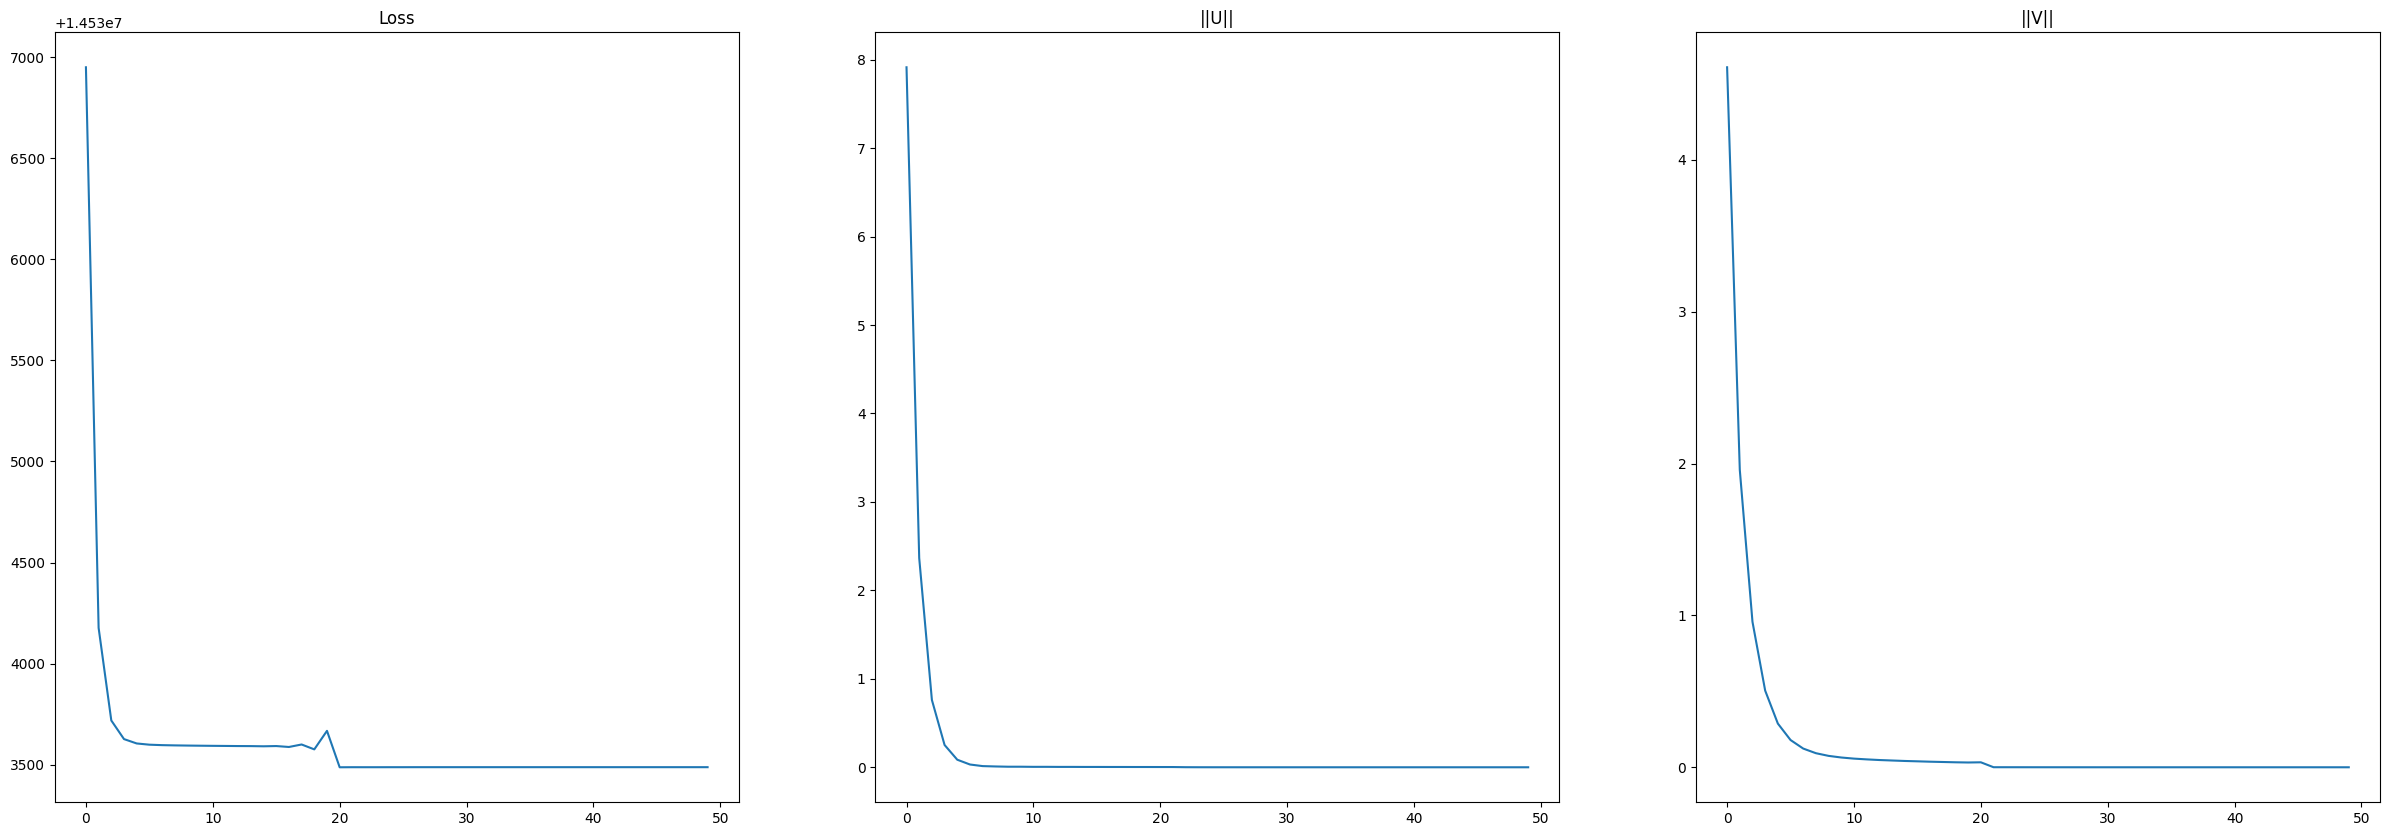

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(30, 10))

axs[0].set_title('Loss')
axs[0].plot(losses)

axs[1].set_title('||U||')
axs[1].plot(U_n)

axs[2].set_title('||V||')
axs[2].plot(V_n)

In [24]:
test_user_inds, U_norms = model.add_unknown_user(test_interations, test_data, n_iters=100, lr=1e-4, batch_size=100) # Add unknown users to user_matrix of our model
preds = model.predict(test_user_inds, np.arange(data_description['n_items'])) # Predict probabilities for unknown users
downvote_seen_items(preds, test_val, data_description)
preds = cp.argsort(preds)[:, -20:].get()

hr, mrr, cov, ndcg = model_evaluate(preds, hold_val, data_description, topn=20) # The score upper the first baseline without choosing hyperparameters for not fully tuned model
print(f'Sigma: {1e-1} \t HR@20: {float(hr):.4f} \t MRR@20: {float(mrr):.4f} \t COV: {float(cov):.4f} \t NDCG@20: {float(ndcg):.4f}')

Sigma: 0.1 	 HR@20: 0.0673 	 MRR@20: 0.0096 	 COV: 0.0638 	 NDCG@20: 0.0214


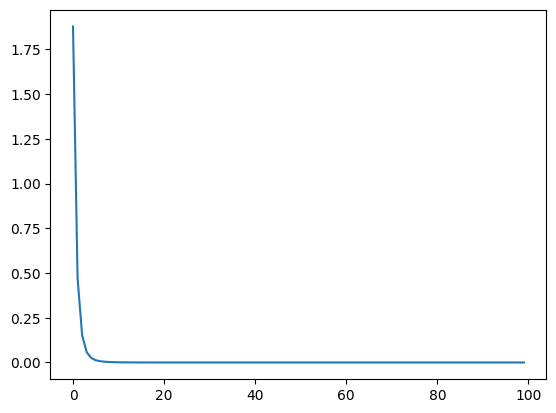

In [25]:
plt.plot(U_norms)

# Hyperparameter tuning

  0%|          | 0/50 [00:00<?, ?it/s]

Dec rank: 5 	 HR@20: 0.0424 	 MRR@20: 0.0058 	 COV: 0.0748 	 NDCG@20: 0.0133


  0%|          | 0/50 [00:00<?, ?it/s]

Dec rank: 10 	 HR@20: 0.0599 	 MRR@20: 0.0075 	 COV: 0.0674 	 NDCG@20: 0.0182


  0%|          | 0/50 [00:00<?, ?it/s]

Dec rank: 15 	 HR@20: 0.0574 	 MRR@20: 0.0063 	 COV: 0.0638 	 NDCG@20: 0.0167


  0%|          | 0/50 [00:00<?, ?it/s]

Dec rank: 20 	 HR@20: 0.0648 	 MRR@20: 0.0088 	 COV: 0.0679 	 NDCG@20: 0.0201


  0%|          | 0/50 [00:00<?, ?it/s]

Dec rank: 25 	 HR@20: 0.0623 	 MRR@20: 0.0071 	 COV: 0.0690 	 NDCG@20: 0.0183


  0%|          | 0/50 [00:00<?, ?it/s]

Dec rank: 30 	 HR@20: 0.0736 	 MRR@20: 0.0083 	 COV: 0.0646 	 NDCG@20: 0.0214


  0%|          | 0/50 [00:00<?, ?it/s]

Dec rank: 35 	 HR@20: 0.0736 	 MRR@20: 0.0134 	 COV: 0.0654 	 NDCG@20: 0.0255


  0%|          | 0/50 [00:00<?, ?it/s]

Dec rank: 40 	 HR@20: 0.0698 	 MRR@20: 0.0094 	 COV: 0.0654 	 NDCG@20: 0.0215


  0%|          | 0/50 [00:00<?, ?it/s]

Dec rank: 45 	 HR@20: 0.0773 	 MRR@20: 0.0126 	 COV: 0.0654 	 NDCG@20: 0.0257


  0%|          | 0/50 [00:00<?, ?it/s]

Dec rank: 50 	 HR@20: 0.0798 	 MRR@20: 0.0134 	 COV: 0.0641 	 NDCG@20: 0.0268


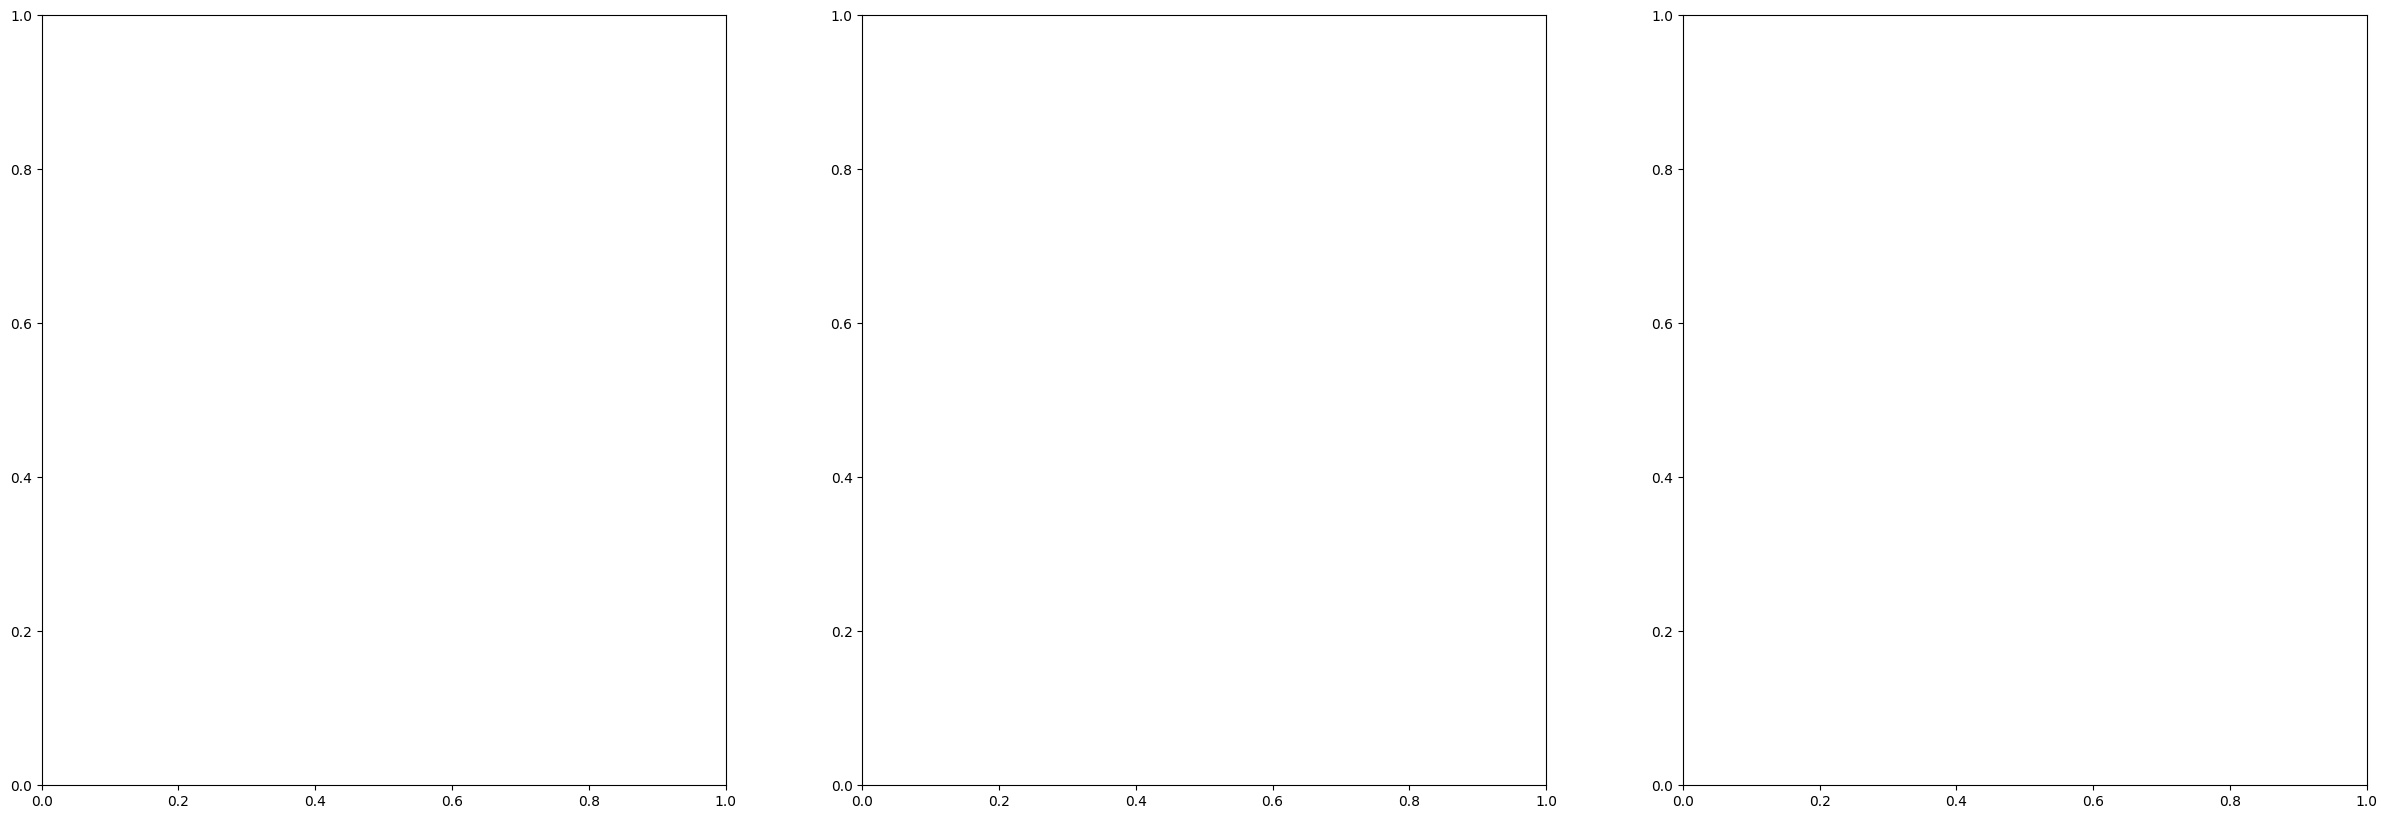

In [66]:
decomp_ranks = (np.arange(10) + 1) * 5

train_interations, train_data = generate_interactions_matrix(train_val, data_description, False, backend=cp)
test_interations, test_data = generate_interactions_matrix(test_val, data_description, True, backend=cp)

results = []

# fig, axs = plt.subplots(1, 3, figsize=(30, 10))

for d in decomp_ranks:

    model = HyperbolicMF(sigma_U=1e-2, sigma_V=1e-2, backend=cp)
    losses, U_n, V_n = model.fit(train_interations, train_data, num_epochs=50, learning_rate=1e-4, decomposition_rank=d, batch_size=200)

    test_user_inds, U_norms = model.add_unknown_user(test_interations, test_data, n_iters=100, lr=1e-4, batch_size=200) # Add unknown users to user_matrix of our model
    preds = model.predict(test_user_inds, np.arange(data_description['n_items'])) # Predict probabilities for unknown users
    downvote_seen_items(preds, test_val, data_description)
    preds = cp.argsort(preds)[:, -20:].get()

    hr, mrr, cov, ndcg = model_evaluate(preds, hold_val, data_description, topn=20) # The score upper the first baseline without choosing hyperparameters for not fully tuned model
    print(f'Dec rank: {d} \t HR@20: {float(hr):.4f} \t MRR@20: {float(mrr):.4f} \t COV: {float(cov):.4f} \t NDCG@20: {float(ndcg):.4f}')

    results.append((hr, mrr, cov, ndcg))

# SSVD

In [61]:
from scipy.sparse.linalg import svds

def rescale_matrix(matrix, scale_factor):
    freqs = matrix.getnnz(axis=0)
    mean_rating = matrix.sum(axis=1) / matrix.getnnz(axis=1).reshape((-1, 1))
    scaling_freqs = np.power(freqs, 0.5 * (scale_factor - 1))
    scaling_rating = np.power(mean_rating, 0.5 * (scale_factor - 1))
    return matrix.multiply(scaling_freqs).multiply(scaling_rating), (scaling_freqs, scaling_rating)

def build_ssvd_model(config, data, data_description):
    _, source_matrix = generate_interactions_matrix(data, data_description, rebase_users=False)
    # scaled_matrix, scale_weights = rescale_matrix(source_matrix, config['scaling'])
    # scaled_matrix, scale_weights = rescale_matrix(source_matrix, config['scaling'])
    _, _, vt = svds(source_matrix, k=config['rank'], return_singular_vectors='vh')
    # singular_values = s[::-1]
    item_factors = np.ascontiguousarray(vt[::-1, :].T)
    return item_factors#, scale_weights

def ssvd_scoring(item_factor_trunc, testset, data_description):
    _, matrix = generate_interactions_matrix(testset, data_description, rebase_users=True)
    scores = (matrix @ item_factor_trunc) @ item_factor_trunc.T
    downvote_seen_items(scores, testset, data_description)
    return scores

def ssvd_grid_search(ranks, scalings, training, testset, holdout, data_description, topn=20):
    max_rank = max(ranks)
    results = {}
    for scaling in scalings:
        # config = {'rank': max_rank, 'scaling': scaling}
        config = {'rank': max_rank, 'scaling': scaling}
        item_factors = build_ssvd_model(config, training, data_description)
        for rank in ranks:
            # config = {'rank': rank, 'scaling': scaling}
            item_factor_trunc = item_factors[:, :rank]
            scores = ssvd_scoring(item_factor_trunc, testset, data_description)
            recs = cp.argsort(scores)[:, -20:]#topn_recommendations(scores, topn-topn)
            results[(rank, scaling)] = model_evaluate(recs, holdout, data_description)
    return results

In [62]:
results_ssvd = ssvd_grid_search(decomp_ranks, [0], train_val, test_val, hold_val, data_description)

Text(0.5, 0, 'Decomposition rank')

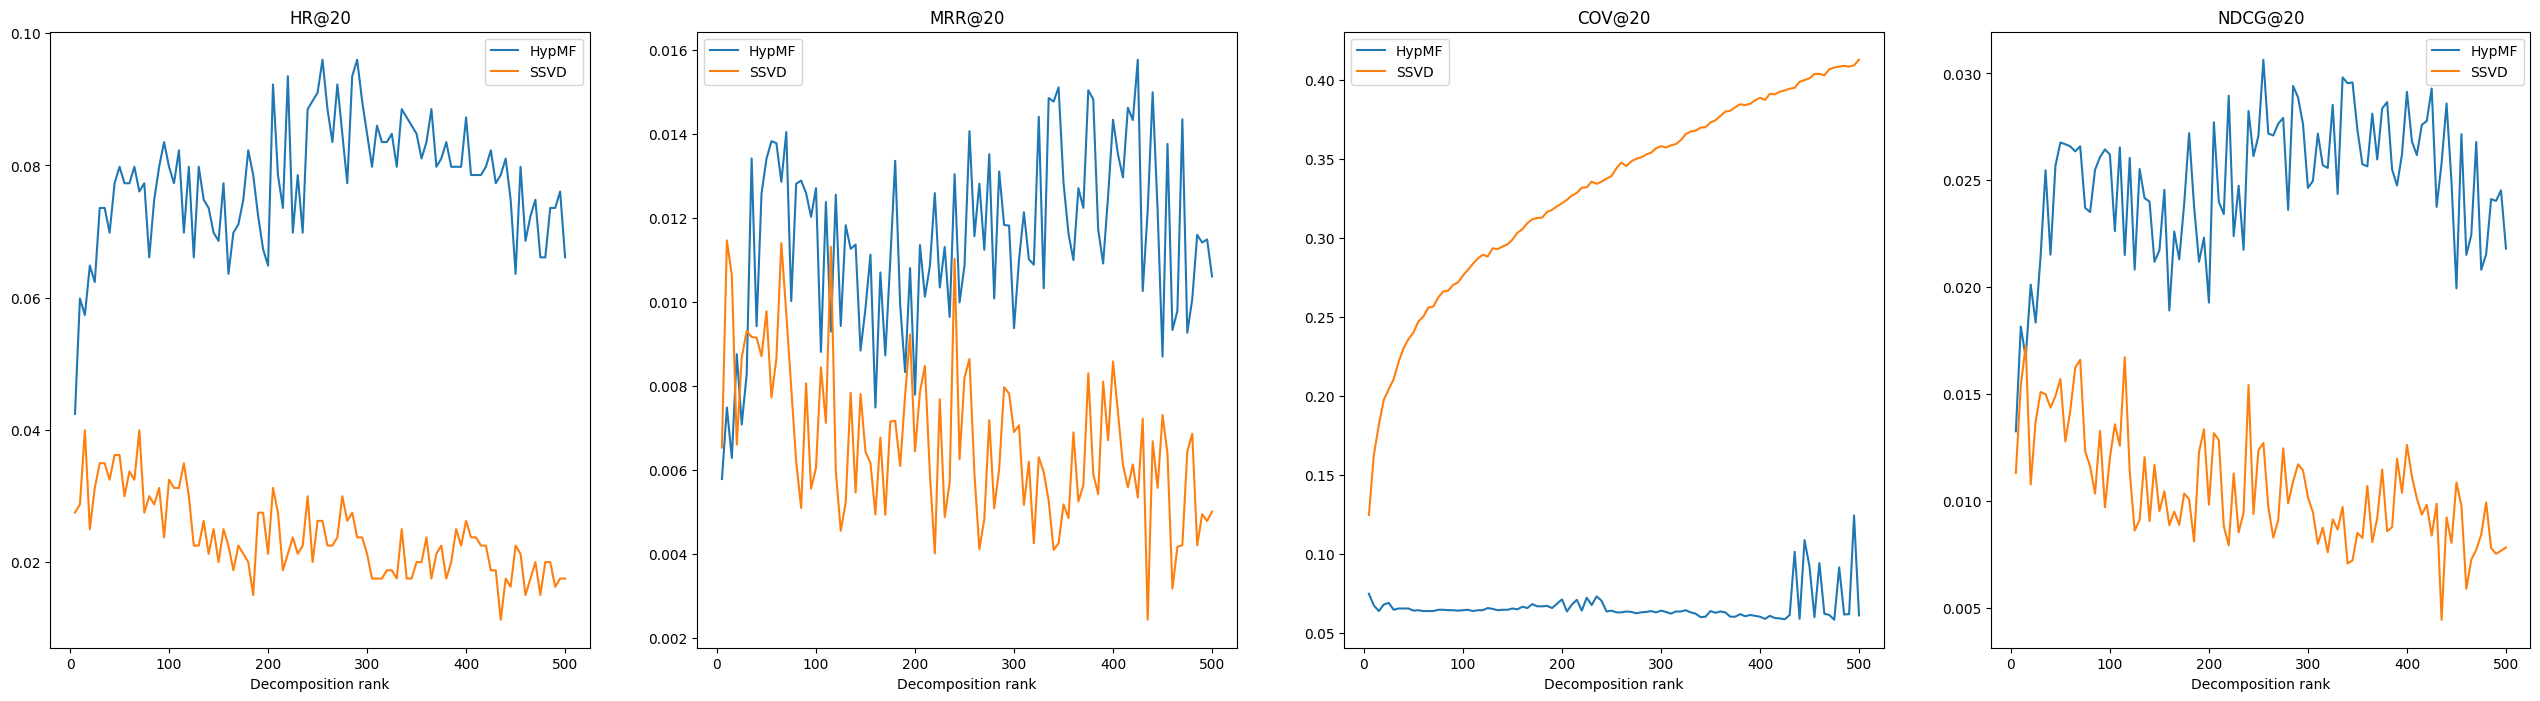

In [65]:
fig, axs = plt.subplots(1, 4, figsize=(32, 8))
results = np.array(results)

axs[0].plot(decomp_ranks, results[:, 0], label='HypMF')
axs[0].plot(decomp_ranks, [results_ssvd[(i, 0)][0] for i in decomp_ranks], label='SSVD')
axs[0].set_title('HR@20')
axs[0].legend()
axs[0].set_xlabel('Decomposition rank')

axs[1].plot(decomp_ranks, results[:, 1], label='HypMF')
axs[1].plot(decomp_ranks, [results_ssvd[(i, 0)][1] for i in decomp_ranks], label='SSVD')
axs[1].set_title('MRR@20')
axs[1].legend()
axs[1].set_xlabel('Decomposition rank')

axs[2].plot(decomp_ranks, results[:, 2], label='HypMF')
axs[2].plot(decomp_ranks, [results_ssvd[(i, 0)][2] for i in decomp_ranks], label='SSVD')
axs[2].set_title('COV@20')
axs[2].legend()
axs[2].set_xlabel('Decomposition rank')

axs[3].plot(decomp_ranks, results[:, 3], label='HypMF')
axs[3].plot(decomp_ranks, [results_ssvd[(i, 0)][3] for i in decomp_ranks], label='SSVD')
axs[3].set_title('NDCG@20')
axs[3].legend()
axs[3].set_xlabel('Decomposition rank')